In [1]:
# standard Python packages for scientific computing:
import numpy as np  # Numerical Python
import matplotlib.pyplot as plt  # plotting
import math as m
import os  # operating system / file utilities
import sys
from timestep import *

    
# from numba import jit
# first did "conda install numba".  See
# https://numba.readthedocs.io/en/stable/user/5minguide.html

In [2]:
# default figure size okay if notebook is zoomed for class presentation:
# plt.rcParams["figure.figsize"] = [6.4, 4.8] # default
plt.rcParams["figure.figsize"] = [8.0, 6.0]Sirawich

In [3]:
# create a subdirectory to hold figures
# (if it doesn't exist already)
os.makedirs("../figs", exist_ok=True)

In [117]:
def init_smooth(N):
    # created the grid
    x = np.linspace(0, 1, N+1)
    x = (x[0:-1] + x[1:]) / 2
    u = np.zeros(np.size(x))
    
    # set initial conditions
    u = 1 * np.exp(- (x-0.5) ** 2 / 0.1 ** 2)
    
    return x, u

In [118]:
def init_step(N):
    # created the grid
    x = np.linspace(0, 1, N+1)
    x = (x[0:-1] + x[1:]) / 2
    u = np.zeros(np.size(x))
    
    # set initial conditions
    u = 1 * np.exp(- (x-0.3) ** 2 / 0.07 ** 2)
    where = np.where(np.abs(x-0.7) <= 0.1)[0]
    u[where] = 1

    return x, u

### Functions for shallow water wave propagation

In [224]:
def find_uL_uR(x, u):
    alpha = 4
    
    u1 = (7/12 * (u + np.roll(u, -1))) - (1/12 * (np.roll(u, 1) + np.roll(u, -2)))
    
    uMPL = u + minmod(np.roll(u, -1) - u, alpha * (u - np.roll(u, 1)))
    uL = median(u1, u, uMPL)
    uMPR = np.roll(u, -1) + minmod(u - np.roll(u, -1), \
                                   alpha * (np.roll(u, -1) - np.roll(u, -2)))
    uR = median(u1, np.roll(u, -1), uMPR)
    
    return uL, uR

In [227]:
def flux_hat(h, u, b):
    f = np.array([u*h, 1/2*(u**2)+g*(h+b)])
    return f

In [271]:
def flux(x, q, b):
    c_abs = np.abs(q[1,:]) + np.sqrt(g * q[0,:])
    c_max = maxmax(c_abs, np.roll(c_abs, -1)) * 1.1
    
    hL, hR = find_uL_uR(x, q[0,:])
    uL, uR = find_uL_uR(x, q[1,:])
    
    f_hatL = flux_hat(hL, uL, b)
    f_hatR = flux_hat(hR, uR, b)
    
    f = 1/2 * (f_hatL + f_hatR) - 1/2 * np.abs(c_max) * np.array([hR - hL, uR - uL])
    return f

In [232]:
# advect 1 step
def advect_1step(x, q, b, g, t0, dt):
    # here assumes uniform grid
    dx = x[1] - x[0]
    
    w0 = q
    f0 = flux(x, w0, b)
    #w3 = w0 + (dt/dx) * (-f0 + np.roll(f0, 1))
    w1 = w0 + (dt / dx) * (- f0 + np.roll(f0, 1))
    f1 = flux(x, w1, b)
    w2 = 3/4 * w0 + 1/4 * (w1 + (dt / dx) * (- f1 + np.roll(f1, 1)))
    f2 = flux(x, w2, b)
    w3 = 1/3 * w0 + 2/3 * (w2 + (dt / dx) * (- f2 + np.roll(f2, 1)))
    q_next = w3
    
    t = t0 + dt
    
    return q_next, t

## New Run

In [397]:
# gravity acceleration
g = 1
# depth scale
b_0 = -10
# initial velocity
u_0 = 0
# number of grid points
N = 100
# intialization of profile (TODO)
x, eta = init_smooth(N)
eta = eta * 0.5
# bathymetry elevation relative to MSL
b = np.ones(np.size(x)) * b_0
# water depth (from bottom to water surface)
h = eta - b
# water speed
u = np.ones(np.size(x)) * u_0
# water wave speed
c = np.sqrt(g * h)

# quantity for computation
q = np.array([h, u])
q_init = q

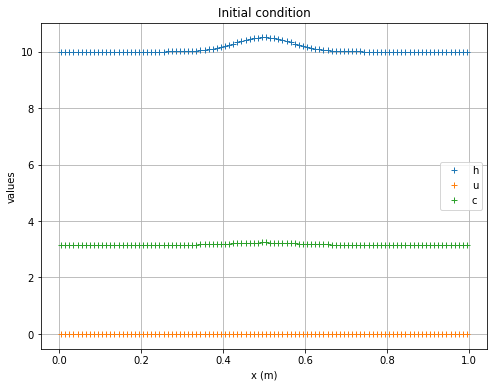

In [395]:
plt.plot(x, q[0,:], '+', label = 'h')
plt.plot(x, q[1,:], '+', label = 'u')
plt.plot(x, c, '+', label = 'c')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.title('Initial condition')
plt.show()

In [368]:
c_abs = np.abs(q[1,:]) + np.sqrt(g * q[0,:])
c_max = maxmax(c_abs, np.roll(c_abs, -1)) * 1.1

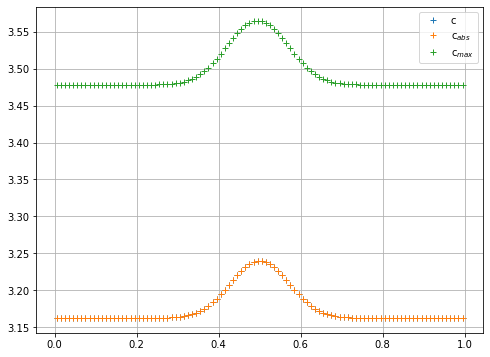

In [369]:
plt.plot(x, c, '+', label = 'c')
plt.plot(x, c_abs, '+', label = 'c$_{abs}$')
plt.plot(x, c_max, '+', label = 'c$_{max}$')
plt.grid()
plt.legend()
plt.show()

In [225]:
hL, hR = find_uL_uR(x, h)
uL, uR = find_uL_uR(x, u)

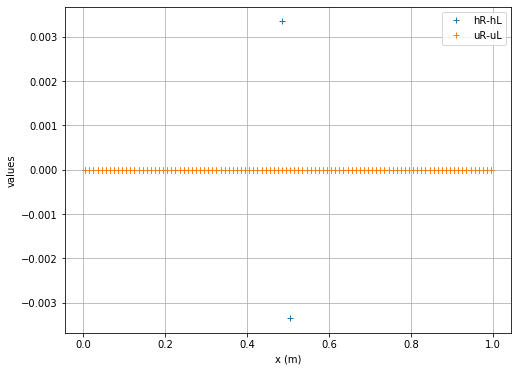

In [226]:
plt.plot(x, hR-hL, '+', label = 'hR-hL')
plt.plot(x, uR-uL, '+', label = 'uR-uL')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.show()

In [229]:
f = flux(x, q, b)

In [230]:
np.shape(f)

(2, 100)

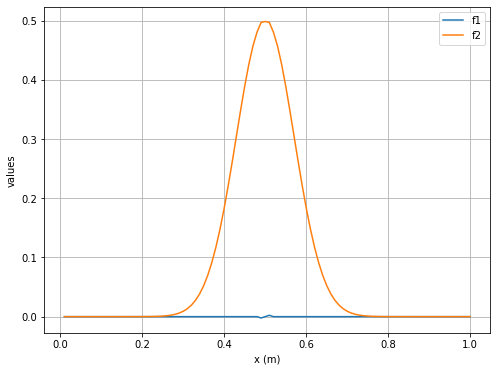

In [231]:
plt.plot(x+(x[1]-x[0])/2, f[0,:], label = 'f1')
plt.plot(x+(x[1]-x[0])/2, f[1,:], label = 'f2')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.show()

In [403]:
t0 = 0
CFL = 0.01
dx = x[1] - x[0]

q = q_init
t = t0

In [404]:
Nsteps = 1000
for ii in range(Nsteps):
    dt = CFL * dx / np.amax(np.abs(q[1,:]) + np.sqrt(g * q[0,:]))
    q, t = advect_1step(x, q, b, g, t, dt)

Text(0.5, 1.0, 't = 0.0306437 s')

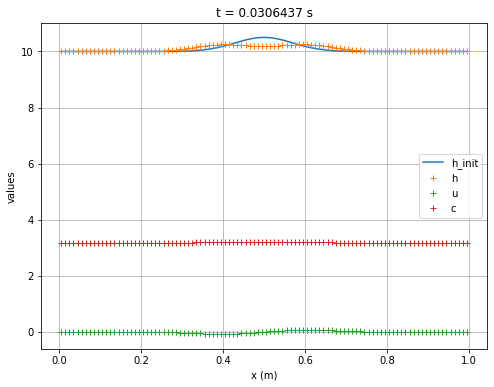

In [405]:
plt.plot(x, q_init[0,:], '-', label = 'h_init')
plt.plot(x, q[0,:], '+', label = 'h')
plt.plot(x, q[1,:], '+', label = 'u')
plt.plot(x, np.sqrt(g * q[0,:]), '+', label = 'c')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.title('t = %.7f s' % t)
#plt.show()

In [350]:
1/dt

16178.059941501166

In [351]:
dt

6.181210872106645e-05

In [383]:
c_abs = np.abs(q[1,:]) + np.sqrt(g * q[0,:])
c_max = maxmax(c_abs, np.roll(c_abs, -1)) * 1.1

hL, hR = find_uL_uR(x, q[0,:])
uL, uR = find_uL_uR(x, q[1,:])

f_hatL = flux_hat(hL, uL, b)
f_hatR = flux_hat(hR, uR, b)

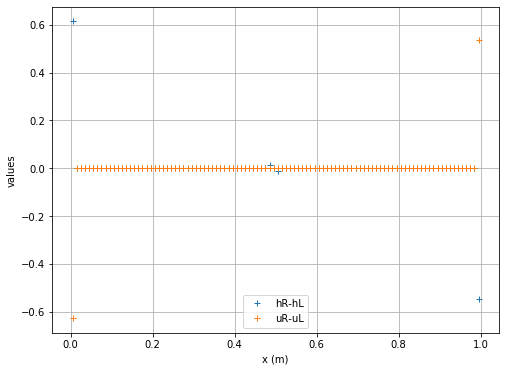

In [384]:
plt.plot(x, hR-hL, '+', label = 'hR-hL')
plt.plot(x, uR-uL, '+', label = 'uR-uL')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.show()

In [385]:
t

0.0007079684903169756

In [386]:
np.sum(q_init[0,:])

112.40717695633862

In [387]:
np.sum(q[0,:])

111.72570485216549

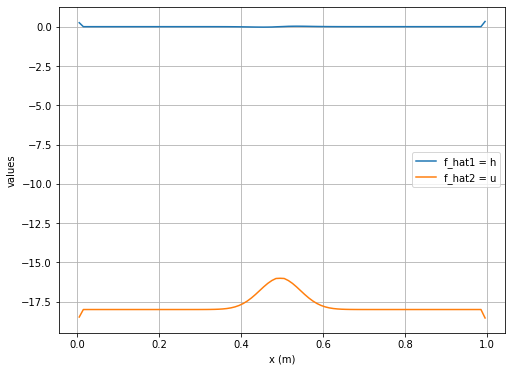

In [388]:
plt.plot(x, f_hatL[0,:] + f_hatR[0,:], label = 'f_hat1 = h')
plt.plot(x, f_hatL[1,:] + f_hatR[1,:], label = 'f_hat2 = u')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.show()

In [364]:
f = flux(x, q, b)

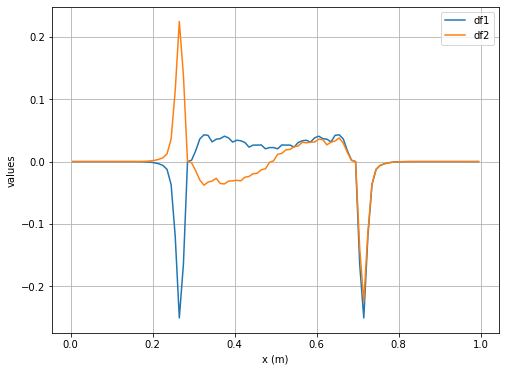

In [365]:
plt.plot(x, np.roll(f,-1)[0,:] - f[0,:], label = 'df1')
plt.plot(x, np.roll(f,-1)[1,:] - f[1,:], label = 'df2')
plt.grid()
plt.xlabel('x (m)')
plt.ylabel('values')
plt.legend()
plt.show()